# Goal: Build singles histogram (in energy space)

Similar to `bhm_e`, we have discovered that we need the singlest histogram in energy space for the $W$ calculation:

$W_{i,j} = \frac{D_{i,j}}{S_i * S_j}$

So go for it. Work off of the singles histogram function in time space and `build_bhm_e`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy.io as sio

In [2]:
sys.path.append('../scripts')
import bicorr as bicorr
import bicorr_e as bicorr_e
import bicorr_math as bicorr_math
import bicorr_sim as bicorr_sim
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
det_df = bicorr.load_det_df()
dict_det_dist = bicorr.build_dict_det_dist()

In [6]:
cced_filename = 'ccedCGMF_slice'
cced_path = '../analysis/cgmf/datar'

os.listdir(cced_path)

['bicorrCGMF_slice',
 'ccedCGMF_slice',
 'fig',
 'singles_hist.npz',
 'singles_hist_e_n.npz']

In [7]:
fig_folder = '../analysis/cgmf/fig'

I don't need to import any timeOffsetData.

In [7]:
# Build channel lists
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists()

# Set up histogram
e_bin_edges, num_e_bins = bicorr_e.build_energy_bin_edges()
singles_hist_e_n = np.zeros((num_dets,num_e_bins),dtype=np.uint64)

# Set up det -> index dictionary
det_indices = np.arange(num_dets)
dict_det_to_index = dict(zip(detList,det_indices))
dict_index_to_det = dict(zip(det_indices,detList)) 

ccedTypeSim = np.dtype([('event', np.int32), 
                    ('detector', np.int8), 
                    ('particle_type', np.int8), 
                    ('time', np.float16), 
                    ('height', np.float32)])
data = np.genfromtxt(os.path.join(cced_path,cced_filename),dtype=ccedTypeSim,usecols=(0,1,2,3,5))
print('Loading data from: ',os.path.join(cced_path,cced_filename))

Loading data from:  ../analysis/cgmf/datar\ccedCGMF_slice


In [24]:
# l is the line number of the current line, starting at 0.
# e is the event number of the current line, starting at 1

# Calculate important things about dt_bin_edges
# Time indices
e_min = np.min(e_bin_edges)
e_max = np.max(e_bin_edges)
e_step = e_bin_edges[1]-e_bin_edges[0]

In [26]:
print_flag = False

# This is a clever way of keeping track what line you're on. Enumerate through the event numbers, `e`, and python also keeps track of the line number `l`.
for l, e in enumerate(tqdm(data['event'],ascii=True)):
    if print_flag: print("Reading line: ",l,"; event: ",e)
    # In this case I don't need to do much logic on the events. I can go line by line and tally them up. Easy.

    event = data[l]
    if event['particle_type'] == 1: # Neutrons
        det   = event['detector']
        dt    = event['time']

        dist   = dict_det_dist[det]
        energy = bicorr_math.convert_time_to_energy(dt,dist)

        if (e_min < energy < e_max):
            e_i = int(np.floor((energy-e_min)/e_step))
            singles_hist_e_n[dict_det_to_index[det],e_i] += 1
            

100%|##########| 10000/10000 [00:00<00:00, 161290.23it/s]


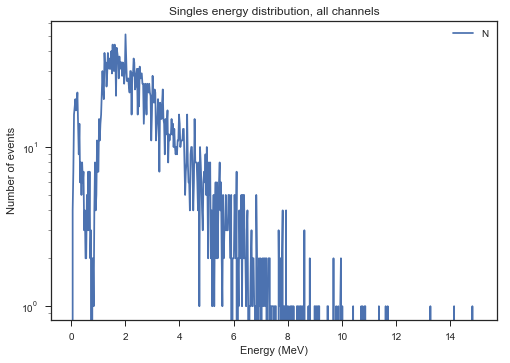

In [28]:
e_bin_centers = bicorr_math.calc_centers(e_bin_edges)
plt.plot(e_bin_centers, np.sum(singles_hist_e_n[:,:],axis=(0)))
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of events')
plt.title('Singles energy distribution, all channels')
plt.legend(['N','G'])
plt.yscale('log')
plt.show()

# Save to disk

In [29]:
np.savez(os.path.join(cced_path,'singles_hist_e_n'),
         singles_hist_e_n=singles_hist_e_n,dict_det_to_index=dict_det_to_index,
         e_bin_edges=e_bin_edges)

# Reload from disk

In [5]:
os.listdir(cced_path)

['bicorrCGMF_slice',
 'ccedCGMF_slice',
 'fig',
 'singles_hist.npz',
 'singles_hist_e_n.npz']

In [7]:
npzfile = np.load(os.path.join(cced_path,'singles_hist_e_n.npz'))
npzfile.files

['dict_det_to_index', 'e_bin_edges', 'singles_hist_e_n']

In [8]:
singles_hist_e_n  = npzfile['singles_hist_e_n']
dict_det_to_index = npzfile['dict_det_to_index']
e_bin_edges       = npzfile['e_bin_edges']

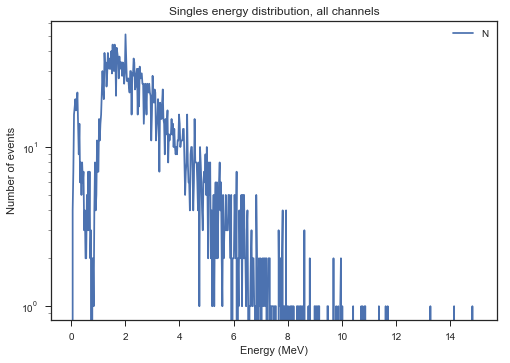

In [9]:
e_bin_centers = bicorr_math.calc_centers(e_bin_edges)
plt.plot(e_bin_centers, np.sum(singles_hist_e_n[:,:],axis=(0)))
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of events')
plt.title('Singles energy distribution, all channels')
plt.legend(['N','G'])
plt.yscale('log')
plt.show()

# Functionalize

In [8]:
help(bicorr_sim.build_singles_hist_sim)

Help on function build_singles_hist_sim in module bicorr_sim:

build_singles_hist_sim(cced_filenames, cced_path, dict_det_dist=None, plot_flag=True, fig_folder='fig', show_flag=False, save_flag=False)
    Parse cced file and generate histogram of singles timing information.
    
    Parameters
    ----------
    cced_filenames : str
        If only one, use list [filename]
    cced_path : str
    dict_det_dist : dict, optional
    plot_flag : bool, optional
    fig_folder : str, optional
    show_flag : bool, optional
    save_flag : bool, optional
    
    Returns
    -------
    singles_hist : ndarray
        Histogram of singles timing information
        Dimension 0: particle type, 0=n, 1=g
        Dimension 1: detector channel
        Dimension 2: dt bin
    dt_bin_edges : ndarray
        Time bin array    
    singles_hist_n_e : ndarray
        Histogram of singles timing information
        Dimension 1: detector channel
        Dimension 2: e bin
    e_bin_edges : ndarray
      

In [9]:
os.listdir(cced_path)

['bicorrCGMF_slice',
 'ccedCGMF_slice',
 'fig',
 'singles_hist.npz',
 'singles_hist_e_n.npz']

Loading data from:  ../analysis/cgmf/datar\ccedCGMF_slice


100%|##########| 10000/10000 [00:00<00:00, 62111.80it/s]


Loading data from:  ../analysis/cgmf/datar\ccedCGMF_slice


100%|##########| 10000/10000 [00:00<00:00, 60975.60it/s]


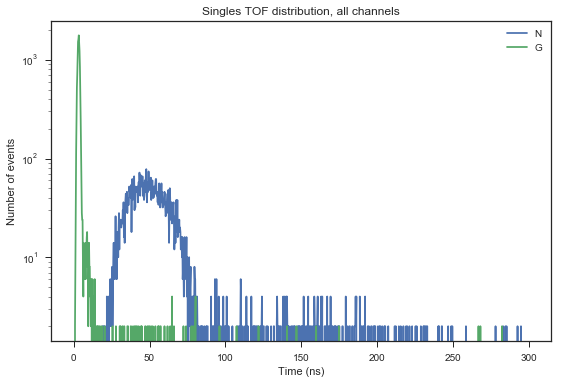

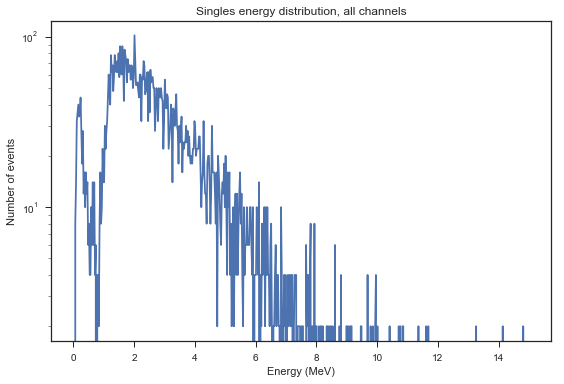

<Figure size 576x396 with 0 Axes>

In [12]:
singles_hist_n_e, e_bin_edges, dict_det_to_index = bicorr_sim.build_singles_hist_sim([cced_filename,cced_filename],cced_path, save_flag=True, show_flag=True)[2:]